In [1]:
import os
import cv2
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import random
import time
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img
from IPython.display import clear_output
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
from numpy import save
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

Now since we have imported out required liberaries 
We will be creating a dataframe to save the image paths with image labels
So, that the images could be fetched in batches when needed without using a lot memory 

In [2]:
df  = pd.DataFrame()

We will be laoding our images with open cv , which loades our image in BGR format instead of RGB format
And resizing our image to required size
This all is done in our helper function image_loader 

In [3]:
def image_loader(image_path , image_size):
    
    ''' give the path
        load the image
        convert to rgb from bgr
        '''
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

    image = cv2.resize(image , image_size ,cv2.INTER_CUBIC)
    return image

Now in dataset_preprocessor we will be accessing the dataset directory and get all the image paths and their labels

In [4]:
def dataset_preprocessing(dataset_path , labels_file_path , image_size,image_paths_pickle):

    




    with open(labels_file_path,"r") as f:
        classes = f.read().split("\n")[:-1]
    

    # images = []
    labels = []
    image_paths = []
    
    for image_name in os.listdir(dataset_path):
        try: 
            image_path = os.path.join(dataset_path ,image_name)
            # images.append(image_loader(image_path ,image_size))
            image_paths.append(image_path)

            for idx in  range(len(classes)):
                if classes[idx] in image_name:
                    labels.append(idx)
            
        except: 
            pass

    with open(image_paths_pickle +".pickle", "wb") as f:
        pickle.dump(image_paths , f)
    print(len(labels))
    assert len(image_paths) == len(labels)
    
    return  np.array(labels),image_paths

Now we got our labels and paths we will store them in a pandas dataframe for furthur use

In [5]:

labels,i = dataset_preprocessing('dataset/train/', 'dataset/labels.txt', (32,32),'harsh')

50000


In [6]:
import gc
gc.collect()

60

In [7]:
df['img_name'] = i
df['labels'] = labels
df.to_csv('train.csv',index=False)
image_size = 32

That is how our pandas dataframe looks like 

In [8]:
df.head()

,img_name,labels
0,dataset/train/0_frog.png,6
1,dataset/train/10000_automobile.png,1
2,dataset/train/10001_frog.png,6
3,dataset/train/10002_frog.png,6
4,dataset/train/10003_ship.png,8


Decoding images is the phase in which we take the address and retrieve the image from the directory

# # Data augmentation


Data augmentation is also very important for saving our model from overfitting and increase our dataset to train the model


<img src="Images/0_Utma-dS47hSoQ6Zt.png" width=800 /> ![](Images/0_Utma-dS47hSoQ6Zt.png)

In [9]:

def decode_image(filename, label=None, image_size=(image_size, image_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, size = image_size)
    
    if label is None:
        return image
    else:
        return image, label

# def data_augment(image, label=None):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    
#     if label is None:
#         return image
#     else:
#         return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_saturation(image, lower = 1, upper = 3)
#     image = tf.image.adjust_brightness(image, delta = 0.3)
    image = tf.image.random_contrast(image, lower = 1, upper = 2)
    if label is None:
        return image
    else:
        return image, label

Here is one sample image from our dataset it is of size (32,32,3)

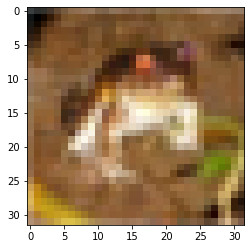

In [10]:
image_folder_path = 'dataset/train'
chosen_image = cv2.imread(os.path.join(image_folder_path, "0_frog.png"))[:,:,::-1]
plt.imshow(chosen_image)

# One hot Encoding

Now we are one hot encoding our labels 
an example for one hot encoding is given below

<img src="Images/mtimFxh.png" width=800 /> ![](Images/mtimFxh.png)


In [11]:
labels = tf.keras.utils.to_categorical(
    labels, num_classes=10, dtype='float32'
)

# Finding for TPUs or GPUs

We can train our model faster by TPUs and GPUs 

In [12]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [13]:
EPOCHS = 20
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

Now its time to get the data from memory address and make mini batches of them
And setting data pipelines 

In [14]:



def get_data(training_data,validation_data):
    labels = tf.keras.utils.to_categorical(training_data.iloc[:,1], num_classes=10, dtype='float32')
    train_dataset_fold = (
        tf.data.Dataset
        .from_tensor_slices((training_data.iloc[:,0], labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .map(data_augment, num_parallel_calls=AUTO)
        .repeat()
        .shuffle(512)
        .batch(BATCH_SIZE)
        .prefetch(AUTO))
    

# Generally we don't shuffle a test/val set at all - 
# only the training set (We evaluate using the entire test set anyway, right? So why shuffle?).
# https://stackoverflow.com/questions/56944856/tensorflow-dataset-questions-about-shuffle-batch-and-repeat
# https://stackoverflow.com/questions/49915925/output-differences-when-changing-order-of-batch-shuffle-and-repeat\


    val_labels = labels = tf.keras.utils.to_categorical(validation_data.iloc[:,1], num_classes=10, dtype='float32')
    valid_dataset_fold = (
        tf.data.Dataset
        .from_tensor_slices((validation_data.iloc[:,0], val_labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO))

    # test_dataset = (
    #     tf.data.Dataset
    #     .from_tensor_slices(test_paths)
    #     .map(decode_image, num_parallel_calls=AUTO)
    #     .batch(BATCH_SIZE))
    return train_dataset_fold,valid_dataset_fold

Learning rate is the rate at which our model learns 
we are changing the learning rate according to the loss and having a track on change of learning rate 

Learning rate schedule: 1e-05 to 5e-05 to 1.06e-05


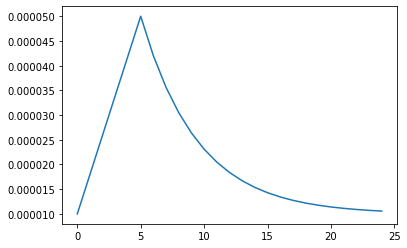

In [15]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

creating checkpoints for our model to save intermediate progras on the bases of the loss improvement on validation data

In [16]:
STEPS_PER_EPOCH = labels.shape[0] // BATCH_SIZE
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('saver/trained_model.h5', monitor='val_loss', verbose=2, save_best_only=True)

# Model selection

We can use many pretrained model but here ill be using a small and simple convolutional net followed by fully conected layers
Even we can use multiple models on the same dataset like using efficient net B0 to B7 
using alternate models allows us to reduce the biasness of the prediction made by one model

<img src="Images/1_uneBBug8GdcSeFviWrefzA.png" width=800 /> ![](Images/1_uneBBug8GdcSeFviWrefzA.png)

In [17]:
import efficientnet.tfkeras as efn
import tensorflow.keras.layers as L
def get_model():
    with strategy.scope():
        model = keras.Sequential()
        model.add(Conv2D(64, kernel_size = (3,3) , strides = (1,1),activation='relu',input_shape=(32,32,3)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(128,kernel_size = (3,3), strides = (1, 1), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(256,kernel_size = (5,5), strides = (1, 1), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(512,kernel_size = (5,5), strides = (1, 1), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())

        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())

        model.add(Dense(256, activation='relu',name  = 'f1'))
        model.add(BatchNormalization())

        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())

        model.add(Dense(1024, activation='relu' , name = 'f2'))
        model.add(BatchNormalization())

        model.add(Dense(10,activation = 'softmax'))
        model.compile(
            optimizer='adam',
            loss = 'categorical_crossentropy', #for multiple categories and classification problem we can use categorical-
            metrics=[tf.keras.metrics.AUC()])  # -cross entropy as loss 
                                               # Computing the approximate AUC (Area under the curve) via a Riemann sum.
    return model

In [18]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        7

In [20]:
training_data,validation_data = train_test_split(df , test_size = 0.2 )

training_dataset_fold  , valid_dataset_fold = get_data(training_data , validation_data)

del training_data,validation_data
gc.collect()



0

In [21]:

history = model.fit(training_dataset_fold,
                        epochs=EPOCHS,
                        callbacks=[model_checkpoint,lr_schedule],
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data = valid_dataset_fold
                        )


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
1562/1562 [==============================] - ETA: 0s - loss: 2.6439 - auc: 0.5746
Epoch 00001: val_loss improved from inf to 2.40981, saving model to saver/trained_model.h5
1562/1562 [==============================] - 29s 19ms/step - loss: 2.6439 - auc: 0.5746 - val_loss: 2.4098 - val_auc: 0.6336 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/20
1559/1562 [============================>.] - ETA: 0s - loss: 2.2874 - auc: 0.6700
Epoch 00002: val_loss improved from 2.40981 to 2.31587, saving model to saver/trained_model.h5
1562/1562 [==============================] - 28s 18ms/step - loss: 2.2870 - auc: 0.6701 - val_loss: 2.3159 - val_auc: 0.6739 - lr: 1.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/20
1562/1562 [==============================] - ETA: 0s - loss: 2.0609 - auc: 0.7383
Epoch 0000

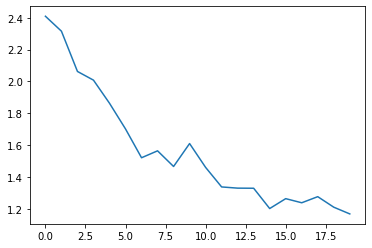

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])